## Using FLUXNET2015 data to compute terrestrial leg of coupling index and compare against CESM models 
<b>Author:</b> Meg D. Fowler <br>
<b>Date:</b> 15 Oct 2020 <br><br>

<b>Information on using FLUXNET data, including how to download various sites, can be found at: https://fluxnet.org </b>

For metadata of location, data is saved here: https://fluxnet.org/sites/site-list-and-pages/, and has been saved into a .csv file manually.

A note on the QC flags based on quick-start guide from above: <br>
* QC flags are available as the varName_QC. For daily and coarser data, the flag "indicates the percentage of measured (_QC=0) or good quality gap-filled (*_QC=1) records aggregated from finer temporal resolutions." <br><br>

It's also important to note that the FLUXNET data is provided in local standard time (so it ignores the presence of Daylight Savings Time). And although the order of columns is *typically* similar between sites, there is no guarantee that it is constant across all sites. 


In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import numpy
import os
import glob
import numpy as np 
import xarray as xr
import datetime
from datetime import date, timedelta
import pandas as pd 
import pickle
import comet as cm
from comet.metrics import utils as gf


## 1. Begin process of reading in FLUXNET data

First, define directory where FLUXNET data is saved:

In [2]:
mainDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/FLUXNET2015/'

Within that directory, you should have some kind of site list saved as a .csv (explanation above). So let's read that in first 

In [3]:
siteInfoFile = mainDir+'SiteList.csv'

# Now read that CSV file into a pandas dataframe 
siteInfoDF = pd.read_csv(siteInfoFile)

# Print out information available:
print('Available site characteristics (metadata) include: \n\n', siteInfoDF.columns.values, '\n')


Available site characteristics (metadata) include: 

 ['SITE_ID' 'SITE_NAME' 'FLUXNET2015' 'FLUXNET-CH4' 'LOCATION_LAT'
 'LOCATION_LONG' 'LOCATION_ELEV' 'IGBP' 'MAT' 'MAP'] 



There's also a downloaded BIF file with lots of metadata you can download with the FLUXNET dataset. This is all in one file and can be a bit clunky, but does allow us to get the depth of soil moisture being used! So let's go ahead and read that in here too. 

In [4]:
metadataFile = mainDir+'FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.xlsx'

# Read in that file 
metadataDF = pd.read_excel(metadataFile)


<b>Now we want to get a list of all the files containing useful data.</b> <br><br>
In this case, I've downloaded the SUBSET data (all sites, but only a selection of available variables). For variable names and definitions, see: https://fluxnet.org/data/fluxnet2015-dataset/subset-data-product/ <br>
For this case, I'd like to get daily data, so the appropriate file suffix is *SUBSET_DD*, where the "DD" implies daily data. In the SUBSET data, you can also access weekly ("WW"), monthly ("MM"), and yearly ("YY"), as well as hourly data ("HH"). <br><br>
The "glob" library will list the full paths to each file matching this string: 

In [5]:
dataFiles = glob.glob(mainDir + 'FLX_*/*SUBSET_DD*')

<b>Let's use a function to read in data from each file, saving only the variables we'll need to compute the terrestrial leg of the coupling index - soil water in the top layer of soil, and sensible heat flux. </b> <br>
Note, however, that the function is designed to be flexible. Any set of variables can be requested with this function. If any of those variables are not found to exist, none are returned (default behavior, but can likely be changed as needed). 

In [6]:
# --------------------------------------------------------
# Function to read requested variables from FLUXNET file. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
# Inputs:  fileName --> Full path to FLUXNET data file 
#          varNames --> An array of variable names to be 
#                       retrieved from said data file. 
#                       NOTE: If you wish to retrieve *all* 
#                       variables, pass the string 'ALL'. 
#  
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the 
#                        requested variables.
#                        Missing values will be set to NaN. 
# 
# --------------------------------------------------------

def readFLUXNET_var(fileName, varNames): 
    # Get ID of station 
    startID   = fileName.find('FLX_')
    fluxnetID = fileName[startID+4:startID+10]
    
    # print('Reading in site - ', fluxnetID)
    
    # Read in CSV file containing data 
    dataDF = pd.read_csv(fileName)
    
    # Return ALL variables from dataDF if requested
    if varNames=='ALL':
        fluxnetDF = dataDF
        
        # Set any value that's missing to NaN (not -999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        
        # If time has been requested, reformat to pandas make index
        fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
        fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        fluxnetDS = fluxnetDF.to_xarray()
            
    # Reduce returned DF to contain only variables of interest  
    else:
        
        # Check that requested variables are available in specific file
        errCount = 0                       # Initialize flag for error 
        colNames = dataDF.columns.values   # Available variables in file 
        
        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames)==False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))
                
                # If any variable is not conatined in file, return a NaN 
                fluxnetDS = -999
                errCount  = errCount+1
                
        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0: 
            fluxnetDF = dataDF[varNames]
            
            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)
            
            # If time has been requested, reformat to pandas make index
            if ('TIMESTAMP' in varNames)==True:
                fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
                fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()
    
    return(fluxnetID, fluxnetDS)



## 2. Compute terrestrial leg of coupling index at each FLUXNET site

For this calculation, we'll use the package built into the CoMeT libaray to compute the coupling index between top level soil moisture and sensible heat flux as observed at each FLUXNET site having data. 

In [7]:
# Set up a few empty arrays to save data into 
terraCI_fluxnet   = np.full([len(dataFiles), 4], np.nan)
startTime_fluxnet = np.zeros(len(dataFiles), dtype='datetime64[s]')
endTime_fluxnet   = np.zeros(len(dataFiles), dtype='datetime64[s]')
lat_fluxnet       = np.full([len(dataFiles)], np.nan)
lon_fluxnet       = np.full([len(dataFiles)], np.nan)
    
# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','SWC_F_MDS_1','SWC_F_MDS_1_QC']

# Loop over each station (data file)
for iStation in range(len(dataFiles)):
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation            = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['SWC_F_MDS_1']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['SWC_F_MDS_1'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
        
        # Save first and last time used for computing CI 
        startTime_fluxnet[iStation] = fluxnetDS['TIMESTAMP'].values[0]
        endTime_fluxnet[iStation]   = fluxnetDS['TIMESTAMP'].values[-1]
                
        # Compute terrestrial coupling metric
        terraLeg = cm.metrics.CouplingIndex()
        terraLeg = terraLeg.compute(fluxnetDS, xname    ='SWC_F_MDS_1', 
                                               yname    ='H_F_MDS',
                                               averaging='season')
        
        # If there's less than one full year of data, don't use station
        if len(terraLeg.season)==4:
            terraCI_fluxnet[iStation,:] = terraLeg.SWC_F_MDS_1_H_F_MDS_CI.values


No data for station:   US-ORv
No data for station:   US-WPT
No data for station:   DE-RuR
No data for station:   RU-Cok
No data for station:   RU-Che
No data for station:   AR-Vir
No data for station:   US-Ne2
No data for station:   US-Wi1
No data for station:   US-Wi2
No data for station:   IT-La2
No data for station:   US-Wi9
No data for station:   US-Wi6
No data for station:   US-Tw4
No data for station:   DE-Zrk
No data for station:   GL-NuF
No data for station:   NL-Hor
No data for station:   US-Los
No data for station:   DE-Spw
No data for station:   US-Atq
No data for station:   US-Myb
No data for station:   GL-ZaF
No data for station:   CG-Tch
No data for station:   DE-Akm
No data for station:   US-Wi5
No data for station:   ES-Ln2
No data for station:   US-Ivo
No data for station:   CZ-wet
No data for station:   US-GBT
No data for station:   AU-Cum
No data for station:   SJ-Adv
No data for station:   US-Wi0
No data for station:   US-Ne3
No data for station:   BR-Sa1
No data fo

I'd like to print/save a few summary statistics from the Fluxnet data:

In [8]:
print('Number of FLUXNET stations with CI calculated: %i' % len(np.where(np.isfinite(terraCI_fluxnet[:,1])==True)[0]))


Number of FLUXNET stations with CI calculated: 153


In [9]:
# How many months go into each calculation of CI for JJA? 
nMonths = np.full([len(dataFiles)], np.nan)

for iSt in range(len(dataFiles)):
    if np.isfinite(terraCI_fluxnet[iSt,1]):
        dateRange      = pd.date_range(start=startTime_fluxnet[iSt],end=endTime_fluxnet[iSt],freq='M')
        nMonths[iSt]   = len(np.where((dateRange.month>=6) & (dateRange.month<=8))[0])
        
print('Minimum number of months used for JJA mean CI: %i ' % int(np.nanmin(nMonths)) )
print('Maximum number of months used for JJA mean CI: %i ' % int(np.nanmax(nMonths)))

Minimum number of months used for JJA mean CI: 1 
Maximum number of months used for JJA mean CI: 57 


Station ID:  AU-Lox
Station lat: -34.470400
Station lon: 140.655100


(733194.0, 733377.0)

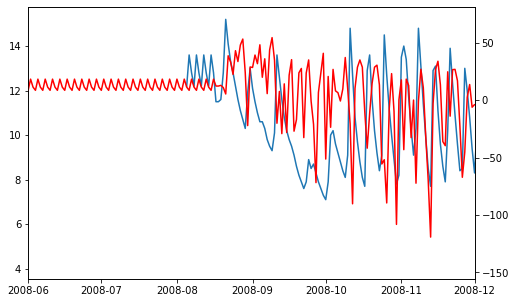

In [10]:
# Investigate these places with only 1 month going into seasonal average... 
iMin = np.where(nMonths==np.nanmin(nMonths))[0]
fluxnetID_min, fluxnetDS_min = readFLUXNET_var(dataFiles[iMin[0]], varNames)

print('Station ID:  %6s' % fluxnetID_min)
print('Station lat: %6f' % lat_fluxnet[iMin[0]])
print('Station lon: %6f' % lon_fluxnet[iMin[0]])

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(fluxnetDS_min.TIMESTAMP, fluxnetDS_min.SWC_F_MDS_1)
ax2=ax1.twinx()
ax2.plot(fluxnetDS_min.TIMESTAMP, fluxnetDS_min.H_F_MDS,'r')
ax1.set_xlim([datetime.date(2008,6,1), datetime.date(2008,12,1)])


### 2.1 Check depth of soil moisture used

The depth of soil moisture is only reported in the metadata BIF file. So let's go through each site and if terraCI_fluxnet was computed - what was the depth of soil moisture used? It's reported in [m] so we've been using a depth of 0.10 (10 cm). 

In [11]:
# Empty array to store depth 
SWCdepth = np.full([len(dataFiles)], np.nan)

for iSt in range(len(dataFiles)):
    
    # If JJA coupling index was computed (there was data)...
    if np.isfinite(terraCI_fluxnet[iSt,1])==True:
        
        # Get station ID 
        fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iSt], varNames)
        
        # Get metadata for said station 
        metaData_station = metadataDF[metadataDF.SITE_ID==fluxnetID]
        
        # Get index where SWC info starts 
        iSWC = np.where(metaData_station.DATAVALUE=='SWC_F_MDS_1')[0]
        
        # Some locations (5) have two measurements recorded 
        if len(iSWC)>1: 
            print('Two measurements for %s' % fluxnetID)
            
            for iDepth in range(len(iSWC)): 
                SWC_DF   = metaData_station[iSWC[iDepth]:iSWC[iDepth]+4]
                depth    = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE).astype(float)
                # Manual check of depths... 
                print('      depth %i: %f' % ((iDepth+1), depth))
                
                # Keep deepest level as the depth for station 
                if iDepth==0:
                    SWCdepth[iSt] = depth 
                else: 
                    if depth<SWCdepth[iSt]: 
                        SWCdepth[iSt] = depth 
                        
        # If staiton only has one level recorded, things are a bit easier:             
        else: 
            SWC_DF        = metaData_station[iSWC[0]:iSWC[0]+4]
            SWCdepth[iSt] = np.asarray(SWC_DF[SWC_DF.VARIABLE=='VAR_INFO_HEIGHT'].DATAVALUE).astype(float)



Two measurements for IT-CA3
      depth 1: -0.150000
      depth 2: -0.050000
Two measurements for IT-BCi
      depth 1: -0.100000
      depth 2: -0.035000
Two measurements for BE-Vie
      depth 1: -0.020000
      depth 2: -0.050000
Two measurements for NL-Loo
      depth 1: -0.100000
      depth 2: -0.030000
Two measurements for IT-CA2
      depth 1: -0.150000
      depth 2: -0.050000


Let's limit usage to depths less than 20 cm (arbitrary, but I don't want us using non-surface soil moisture for this application). This will eliminate 11 stations.

In [13]:
# Get stations with SWC from below 20 cm 
iLimit = np.where(SWCdepth<-0.2)[0]

# Set the terrestrial leg of CI to missing so we don't consider those 
terraCI_fluxnet[iLimit,:] = np.nan

print('Number of FLUXNET stations to use with reasonable depths of SWC: %i' % len(np.where(np.isfinite(terraCI_fluxnet[:,1])==True)[0]))


Number of FLUXNET stations to use with reasonable depths of SWC: 142


<ipython-input-13-9f43261e299b>:2: RuntimeWarning: invalid value encountered in less
  iLimit = np.where(SWCdepth<-0.2)[0]


It would also be good to put some time limits on this. So let's say the observations need to have at least 9 months of data for JJA means (3-years). Otherwise, set terraCI to np.nan again so we don't use it. 

In [22]:
# Get stations with less than 9 months used for JJA terrestrial CI 
iLimit = np.where(nMonths<9)[0]

# Set to missing so we don't consider stations with less than three years of data going into the average 
terraCI_fluxnet[iLimit,:] = np.nan

print('Number of FLUXNET stations to use with 3+ years of JJA data: %i' % len(np.where(np.isfinite(terraCI_fluxnet[:,1])==True)[0]))


Number of FLUXNET stations to use with 3+ years of JJA data: 117


<ipython-input-22-3588e5aec85b>:2: RuntimeWarning: invalid value encountered in less
  iLimit = np.where(nMonths<9)[0]


## 3. Compare terrestrial leg of the coupling index to what's been found in our CESM2 simulations

The first step is to read in the coupling index that's been computed previously for different versions of CESM. These in particular are based on daily data for 10-11cm soil moisture and sensible heat flux. 

In [14]:
# Define directory where files are saved 
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/'

# Filenames for CI(SM_10cm, SHFLX)
CESM2_file = dataDir+'TerraLeg_coupling_shf_vs_soilm_1979-2006.nc'  
CESM1_file = dataDir+'TerraLeg_coupling_shf_vs_soilm_CESM1.nc'
CLM45_file = dataDir+'TerraLeg_coupling_shf_vs_soilm_CESM2-CLM45.nc'

# Read those files in
terraLeg_CESM2 = xr.open_dataset(CESM2_file, decode_times=False)
terraLeg_CESM1 = xr.open_dataset(CESM1_file, decode_times=False)
terraLeg_CLM45 = xr.open_dataset(CLM45_file, decode_times=False)

# Save just CI to its own array 
terraCI_CESM2 = terraLeg_CESM2.mrsos_hfss_CI.values
terraCI_CESM1 = terraLeg_CESM1.soilM_10_SHFLX_CI.values
terraCI_CLM45 = terraLeg_CLM45.soilM_10_SHFLX_CI.values

# Save lat/lon for model output
latModel = terraLeg_CESM2.lat.values
lonModel = terraLeg_CESM2.lon.values
season   = terraLeg_CESM2.season.values


### 3.1 Map comparison 

<b>Let's try plotting a map of model CI, with circles of filled colors representing the flux tower estimates at a certain location.</b> <br>
Whenever I make these plots, I use a function that creates a custom colormap to match what's been used in previous studies.


In [15]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    
    import matplotlib as mpl
    import numpy as np
    
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [16]:
### Create a list of RGB tuples for terrestrial leg (SM, SHFLX)
colorsList_SMvSHF = [(124,135,181), 
                     (107,109,161),
                     (51,82,120),
                     (49,114,127),
                     (97,181,89),
                     (200,218,102),
                     (255,242,116),
                     (238,164,58)] # This example uses the 8-bit RGB

my_cmap_SMvSHF = make_cmap(colorsList_SMvSHF, bit=True)


There's a <i>very</i> good chance that this is *not* the most efficient way to map data to the color map I've created above. But I do at least know that it works. <br><br>
So first, let's create a function that maps terrestrial CI to the color ranges defined above. <br>
We'll also need to make the data cyclic for when we map it with cartopy. This is a safety step; otherwise, you can end up with a white stripe of 'missing' data at the dateline just because the plotting function doesn't realize the lons wrap all the way around. <br>

In [17]:
def map_terraCI_colors(data):
    # Empty array the same size as input data, to save color 
    colorsTerraLeg = np.copy(data)
    colorsTerraLeg.fill(np.nan)
    
    # Use color bounds of previous work for easy comparison   
    colorsTerraLeg[np.where(data<-20)]                  = 1
    colorsTerraLeg[np.where((data>-20) & (data<=-15))]  = 2
    colorsTerraLeg[np.where((data>-15) & (data<=-10))]  = 3
    colorsTerraLeg[np.where((data>-10) & (data<=-5))]   = 4
    colorsTerraLeg[np.where((data>-5)  & (data<=-2))]   = 5
    colorsTerraLeg[np.where((data>-2)  & (data<=-1))]   = 6
    colorsTerraLeg[np.where((data>-1)  & (data<=0))]    = 7
    colorsTerraLeg[np.where(data>0)]                    = 8
    
    return(colorsTerraLeg)

In [18]:
# Make data cylic for JJA
TerraLegCESM2_JJA_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(terraCI_CESM2[1,:,:], lonModel)
TerraLegCESM1_JJA_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(terraCI_CESM1[1,:,:], lonModel)
TerraLegCLM45_JJA_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(terraCI_CLM45[1,:,:], lonModel)

# Now get "colorsTerraLeg" (the color aliased version of TerraCI arrays)
colorsTerraLeg_CESM2   = map_terraCI_colors(TerraLegCESM2_JJA_cyclic)
colorsTerraLeg_CESM1   = map_terraCI_colors(TerraLegCESM1_JJA_cyclic)
colorsTerraLeg_CLM45   = map_terraCI_colors(TerraLegCLM45_JJA_cyclic)
colorsTerraLeg_FLUXNET = map_terraCI_colors(terraCI_fluxnet[:,1])


<ipython-input-17-32ce97a1d946>:7: RuntimeWarning: invalid value encountered in less
  colorsTerraLeg[np.where(data<-20)]                  = 1
<ipython-input-17-32ce97a1d946>:8: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg[np.where((data>-20) & (data<=-15))]  = 2
<ipython-input-17-32ce97a1d946>:8: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg[np.where((data>-20) & (data<=-15))]  = 2
<ipython-input-17-32ce97a1d946>:9: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg[np.where((data>-15) & (data<=-10))]  = 3
<ipython-input-17-32ce97a1d946>:9: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg[np.where((data>-15) & (data<=-10))]  = 3
<ipython-input-17-32ce97a1d946>:10: RuntimeWarning: invalid value encountered in greater
  colorsTerraLeg[np.where((data>-10) & (data<=-5))]   = 4
<ipython-input-17-32ce97a1d946>:10: RuntimeWarning: invalid value encountered in less_equal
  colorsTerraLeg[np.where((d

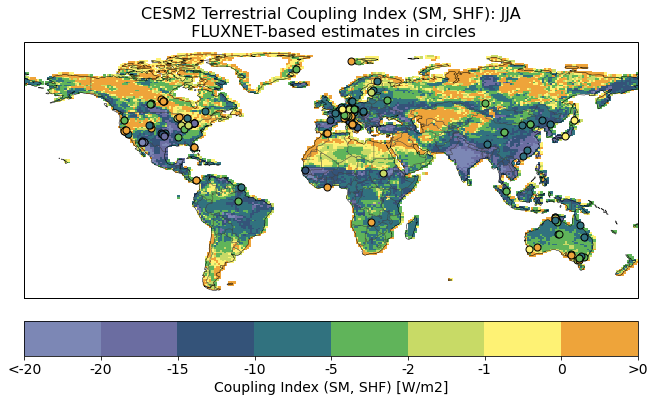

In [23]:
# --- Plot JJA Terrestrial leg 

fig=plt.figure(figsize=(11, 8), facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())   #Set to global ot match previous version
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_cyclic,latModel,colorsTerraLeg_CESM2,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('CESM2 Terrestrial Coupling Index (SM, SHF): JJA\n FLUXNET-based estimates in circles',fontsize=16)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# ----------- Add FluxNet measurements ------------ 
for iStation in range(len(dataFiles)):
    if (np.isfinite(colorsTerraLeg_FLUXNET[iStation])==True):
    
        colorChoice = colorsList_SMvSHF[int(colorsTerraLeg_FLUXNET[iStation]-1)]

        ax.plot(lon_fluxnet[iStation],lat_fluxnet[iStation], 'o',
                markerfacecolor=colorChoice,
                markeredgecolor='k',
                markersize=7,
                transform=ccrs.PlateCarree())


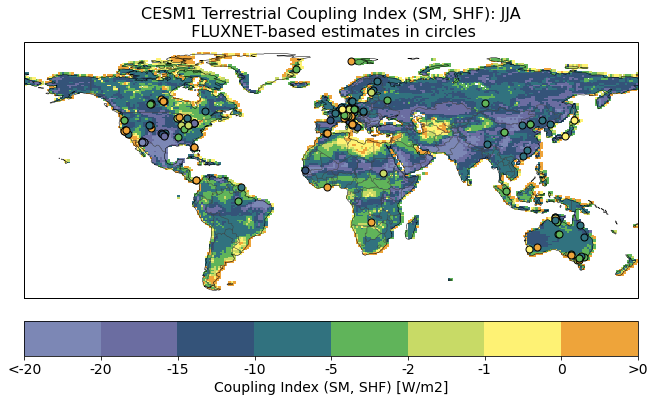

In [24]:
# --- Plot JJA Terrestrial leg 

fig=plt.figure(figsize=(11, 8), facecolor='w', edgecolor='k')

my_fontsize = 14

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())   #Set to global ot match previous version
bounds = [1,2,3,4,5,6,7,8,9]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_cyclic,latModel,colorsTerraLeg_CESM1,norm=norm,
                             cmap=my_cmap_SMvSHF,
                             vmin=1,vmax=9)

# Colorbar
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',ticks=range(13),cax=cbar_ax)
cbar.set_label('Coupling Index (SM, SHF) [W/m2]',fontsize=my_fontsize)
cbar.ax.set_xticklabels(['<-20','-20','-15','-10','-5','-2','-1','0','>0'],fontsize=my_fontsize)  # vertically oriented colorbar

#Additional options 
ax.set_title('CESM1 Terrestrial Coupling Index (SM, SHF): JJA\n FLUXNET-based estimates in circles',fontsize=16)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

# ----------- Add FluxNet measurements ------------ 
for iStation in range(len(dataFiles)):
    if (np.isfinite(colorsTerraLeg_FLUXNET[iStation])==True):
    
        colorChoice = colorsList_SMvSHF[int(colorsTerraLeg_FLUXNET[iStation]-1)]

        ax.plot(lon_fluxnet[iStation],lat_fluxnet[iStation], 'o',
                markerfacecolor=colorChoice,
                markeredgecolor='k',
                markersize=7,
                transform=ccrs.PlateCarree())


### 3.2 RMSE of JJA coupling index 

Let's compute the RMSE over all points that are found to have valid coupling data. <br><br>
So for each FLUXNET station, we need to: <br>
(1) check that it has CI data; <br>
(2) get the lat/lon of the model gridcell that contains the tower; and <br>
(3) take the difference between modeled and observed terrestrial CI. <br> <br>
From there, we square the differences at each site, sum them all together, and divide by the number of sites used. 

In [25]:
# Define empty arrays to save differences in 
terraCI_CESM2diff = np.full([len(dataFiles)], np.nan)
terraCI_CESM1diff = np.full([len(dataFiles)], np.nan)
terraCI_CLM45diff = np.full([len(dataFiles)], np.nan)

# Count number of stations used...
nValidStation = 0

# Consider each station individually 
for iStation in range(len(dataFiles)):
    
    # Isolate station CI for JJA
    fluxnetCI = terraCI_fluxnet[iStation,1]

    # Check that there's data here (and at least 3 months went into JJA avg CI)
    # ------------------------------------------------------------------------
    if ( (np.isnan(fluxnetCI)==False) ): 
        
        # Get model gridcells that match fluxnet site 
        iLat        = np.where( (latModel>=(lat_fluxnet[iStation]-0.4712)) & 
                                (latModel<=(lat_fluxnet[iStation]+0.4712)) )[0]
         # Convert longitude of point into 0-360 range 
        lonSel_flux = (lon_fluxnet[iStation] + 360) % 360                
        iLon        = np.where( (lonModel>=(lonSel_flux-0.625)) & 
                                (lonModel<=(lonSel_flux+0.625)) )[0]
        
        gridValue_CESM2 = terraCI_CESM2[1,iLat,iLon]
        gridValue_CESM1 = terraCI_CESM1[1,iLat,iLon]
        gridValue_CLM45 = terraCI_CLM45[1,iLat,iLon]
        
        # Compare to fluxnet-based estimate
        terraCI_CESM2diff[iStation] = gridValue_CESM2 - fluxnetCI
        terraCI_CESM1diff[iStation] = gridValue_CESM1 - fluxnetCI
        terraCI_CLM45diff[iStation] = gridValue_CLM45 - fluxnetCI

        # Increment counter for number of stations used 
        nValidStation =  nValidStation+1
        

In [26]:
# Compute RMSE per model version 
RMSE_CESM2 = np.sqrt(np.nansum(terraCI_CESM2diff**2) / nValidStation)
RMSE_CESM1 = np.sqrt(np.nansum(terraCI_CESM1diff**2) / nValidStation)
RMSE_CLM45 = np.sqrt(np.nansum(terraCI_CLM45diff**2) / nValidStation)

# Print results of RMSE analysis 
print('Number of stations considered: %i \n' % nValidStation)
print('RMSE between model terrestrial CI and fluxnet-based observations:')
print('     CESM2 RMSE: %8.3f' % RMSE_CESM2)
print('     CESM1 RMSE: %8.3f' % RMSE_CESM1)
print('     CLM45 RMSE: %8.3f' % RMSE_CLM45)

print('\n Mean Bias (model - observations):')
print('     CESM2 Bias: %8.3f' % np.nanmean(terraCI_CESM2diff))
print('     CESM1 Bias: %8.3f' % np.nanmean(terraCI_CESM1diff))
print('     CLM45 Bias: %8.3f' % np.nanmean(terraCI_CLM45diff))


Number of stations considered: 117 

RMSE between model terrestrial CI and fluxnet-based observations:
     CESM2 RMSE:    7.717
     CESM1 RMSE:    8.216
     CLM45 RMSE:   10.373

 Mean Bias (model - observations):
     CESM2 Bias:   -1.529
     CESM1 Bias:   -3.042
     CLM45 Bias:   -6.334


In [95]:
# Testing section 
fileName = dataFiles[0]

# Get ID of station 
startID = fileName.find('FLX_')
fluxnetID = fileName[startID+4:startID+10]
print(fluxnetID, '\n')

dataDF   = pd.read_csv(fileName)

varNames = ['TIMESTAMP','H_F_MDS','SWC_F_MDS_1','SWC_F_MDS_1_QC']

# Check that requested variables are available in specific file
colNames = dataDF.columns.values
print(colNames, '\n')

for iVar in range(len(varNames)):
    if (varNames[iVar] in colNames)==False:
        print('** ERROR: %13s   not contained in file for %8s  **' % 
              (varNames[iVar], fluxnetID))

        testDF = np.nan
        
testDF               = dataDF[varNames]
testDF = testDF.replace(-9999, np.nan)


testDF['TIMESTAMP'] = pd.to_datetime(testDF['TIMESTAMP'].values, format='%Y%m%d')
testDF = testDF.set_index(['TIMESTAMP'])
testDS = testDF.to_xarray()
testDS

iReal      = np.where((np.isfinite(testDS['SWC_F_MDS_1'])==True) & 
                     (np.isfinite(testDS['H_F_MDS'])==True))[0]
testDS  = testDS.isel(TIMESTAMP=iReal)
        

testDS


CA-NS3 

['TIMESTAMP' 'TA_F' 'TA_F_QC' 'SW_IN_POT' 'SW_IN_F' 'SW_IN_F_QC' 'LW_IN_F'
 'LW_IN_F_QC' 'VPD_F' 'VPD_F_QC' 'PA_F' 'PA_F_QC' 'P_F' 'P_F_QC' 'WS_F'
 'WS_F_QC' 'USTAR' 'USTAR_QC' 'NETRAD' 'NETRAD_QC' 'PPFD_IN' 'PPFD_IN_QC'
 'PPFD_OUT' 'PPFD_OUT_QC' 'SW_OUT' 'SW_OUT_QC' 'CO2_F_MDS' 'CO2_F_MDS_QC'
 'TS_F_MDS_1' 'TS_F_MDS_1_QC' 'SWC_F_MDS_1' 'SWC_F_MDS_1_QC' 'G_F_MDS'
 'G_F_MDS_QC' 'LE_F_MDS' 'LE_F_MDS_QC' 'LE_CORR' 'LE_CORR_25' 'LE_CORR_75'
 'LE_RANDUNC' 'H_F_MDS' 'H_F_MDS_QC' 'H_CORR' 'H_CORR_25' 'H_CORR_75'
 'H_RANDUNC' 'NEE_VUT_REF' 'NEE_VUT_REF_QC' 'NEE_VUT_REF_RANDUNC'
 'NEE_VUT_25' 'NEE_VUT_50' 'NEE_VUT_75' 'NEE_VUT_25_QC' 'NEE_VUT_50_QC'
 'NEE_VUT_75_QC' 'RECO_NT_VUT_REF' 'RECO_NT_VUT_25' 'RECO_NT_VUT_50'
 'RECO_NT_VUT_75' 'GPP_NT_VUT_REF' 'GPP_NT_VUT_25' 'GPP_NT_VUT_50'
 'GPP_NT_VUT_75' 'RECO_DT_VUT_REF' 'RECO_DT_VUT_25' 'RECO_DT_VUT_50'
 'RECO_DT_VUT_75' 'GPP_DT_VUT_REF' 'GPP_DT_VUT_25' 'GPP_DT_VUT_50'
 'GPP_DT_VUT_75' 'RECO_SR' 'RECO_SR_N'] 



<xarray.Dataset>
Dimensions:         (TIMESTAMP: 1126)
Coordinates:
  * TIMESTAMP       (TIMESTAMP) datetime64[ns] 2002-09-08 ... 2005-10-07
Data variables:
    H_F_MDS         (TIMESTAMP) float64 20.24 39.42 13.91 ... 15.59 23.15 -9.814
    SWC_F_MDS_1     (TIMESTAMP) float64 15.44 15.33 15.32 ... 27.22 27.09 26.94
    SWC_F_MDS_1_QC  (TIMESTAMP) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0